In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', 500)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

The idea is to cluster clients that accepted one of the above number of different campaigns (or that accepted or not). Clustering ideas from a mixed is challenging, and some concepts analysed here are based on the paper: [Distance-based clustering of mixed data](https://wires.onlinelibrary.wiley.com/doi/abs/10.1002/wics.1456).

In [3]:
data_cleaned = pd.read_csv('dataset/cleaned_marketing_campaign.csv', sep=',')
data_cleaned.head()

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Accepted
0,0,5524,1957,Graduation,Single,58138.0,0,0,2012-04-09,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,0
1,1,2174,1954,Graduation,Single,46344.0,1,1,2014-08-03,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,0
2,2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,0
3,3,6182,1984,Graduation,Together,26646.0,1,0,2014-10-02,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,0
4,4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,0


In [4]:
categorical_features = ['Education', 'Marital_Status', 'Kidhome','Teenhome', 'Complain', 'Response']

numerical_features = ['Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
                      'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
                      'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

X_num = data_cleaned[numerical_features]
X_cat = data_cleaned[categorical_features]

In [5]:
scaler = StandardScaler()
one_hot = OneHotEncoder()

In [6]:
ncat = ['Education', 'Marital_Status', 'Kidhome', 'Teenhome']
X_cat_ncat = one_hot.fit_transform(X_cat[['Education', 'Marital_Status', 'Kidhome', 'Teenhome']])

In [7]:
X_cat_one_hot = np.concatenate((X_cat_ncat.toarray(), X_cat[['Complain', 'Response']].to_numpy()), axis=1)

In [8]:
X_num_norm = scaler.fit_transform(X_num)
X_cat_one_hot_norm = scaler.fit_transform(X_cat_one_hot)

In [9]:
X = np.concatenate((X_num_norm, X_cat_one_hot_norm), axis=1)
y = data_cleaned['Accepted']

print(X_num_norm.shape)
print(X_cat_one_hot_norm.shape)
print(X.shape)

(2205, 13)
(2205, 21)
(2205, 34)


In [14]:
y.unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [15]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=10)

for i, (train_index, test_index) in enumerate(split.split(X, y)):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y.to_numpy()[train_index]
    y_test = y.to_numpy()[test_index]

Using t-SNE to visually grasp the customer segmentation in possible clusters with all the data:

In [25]:
tsne = TSNE(n_components=2)

In [26]:
X_tsne = tsne.fit_transform(X)

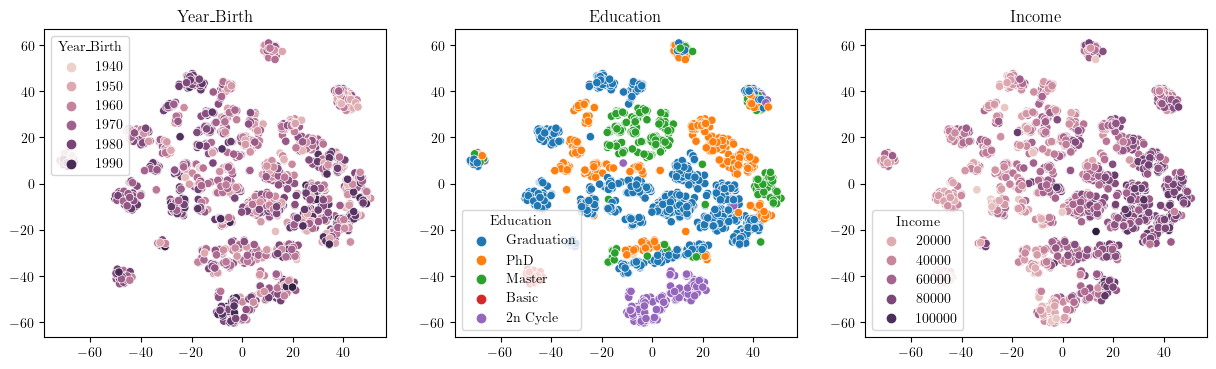

In [27]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

features = ['Year_Birth', 'Education', 'Income']

for i in range(3):
    sn.scatterplot(x=X_tsne[:,0].ravel(), y=X_tsne[:,1].ravel(), marker='o', ax=ax[i], hue=data_cleaned[features[i]])
    ax[i].set_title(features[i])
plt.show()

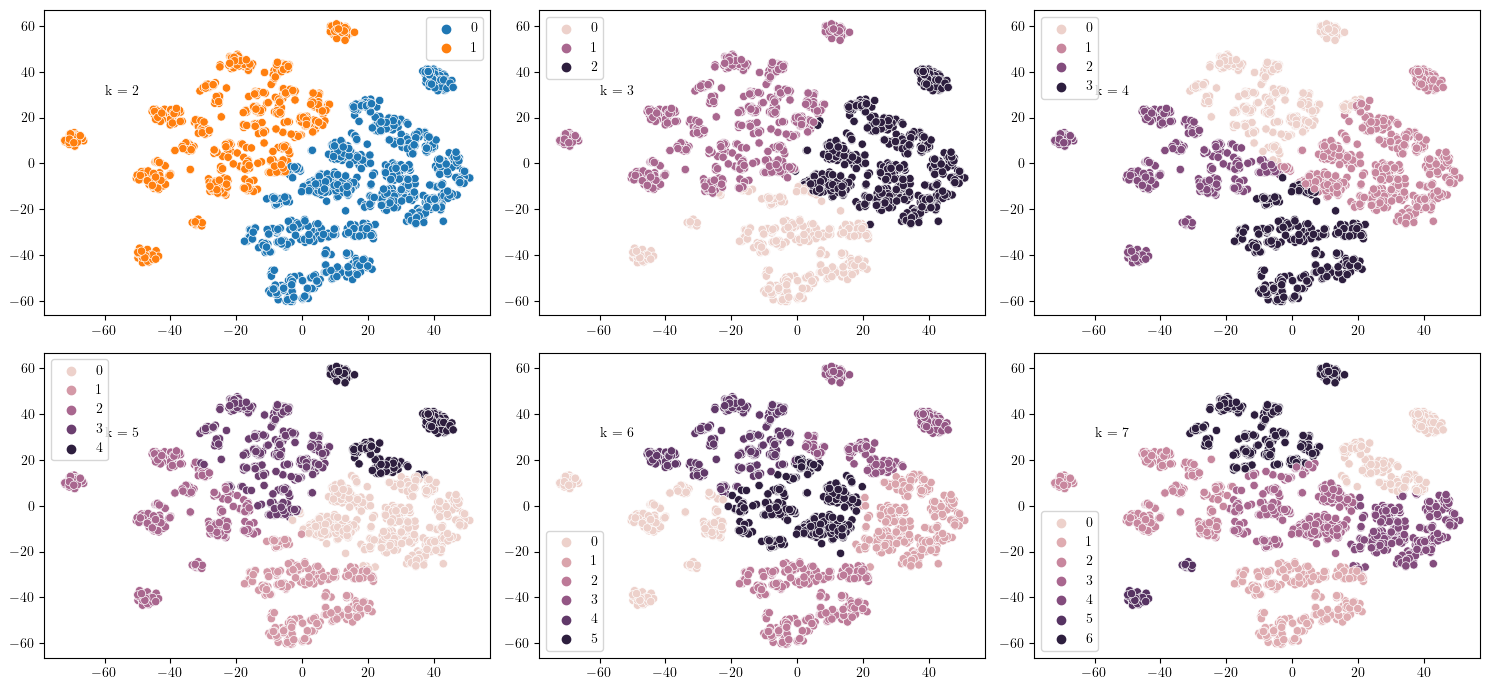

In [35]:
fig, ax = plt.subplots(2,3, figsize=(15,7))

inertia_tsne = []

k = 2
for i in range(2):
    for j in range(3):
        kmeans = KMeans(n_clusters=k, n_init=100)
        y_pred = kmeans.fit_predict(X_tsne)
        inertia_tsne.append(kmeans.inertia_)

        sn.scatterplot(x=X_tsne[:,0].ravel(), y=X_tsne[:,1].ravel(), marker='o', ax=ax[i,j], hue=y_pred)
        ax[i,j].text(-60,30,'k = %i'%k)
        k += 1

plt.tight_layout()
plt.show()

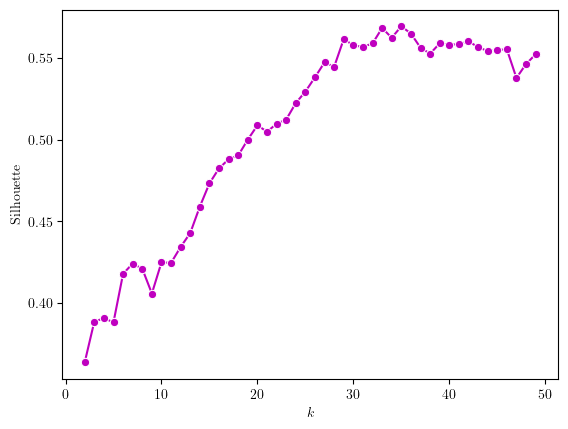

In [20]:
k_list = np.arange(2,50)
silhouette_list = []

for k in k_list:
    kmeans = KMeans(n_clusters=k, n_init=100)
    kmeans.fit_predict(X_tsne)
    s = silhouette_score(X_tsne, kmeans.labels_)
    silhouette_list.append(s)

sn.lineplot(x=k_list, y=silhouette_list, marker='o', color='m')
plt.xlabel(r'$k$')
plt.ylabel('Silhouette')
plt.show()

Now performing the clustering to the whole dataset:

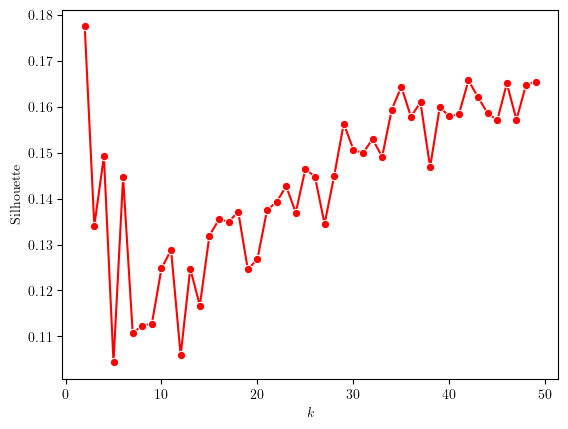

In [43]:
k_list = np.arange(2,50)
silhouette_list = []

for k in k_list:
    kmeans = KMeans(n_clusters=k, n_init=100)
    kmeans.fit_predict(X)
    s = silhouette_score(X, kmeans.labels_)
    silhouette_list.append(s)

ax = sn.lineplot(x=k_list, y=silhouette_list, marker='o', color='r')
ax.set(xlabel=r'$k$', ylabel='Silhouette')
plt.show()

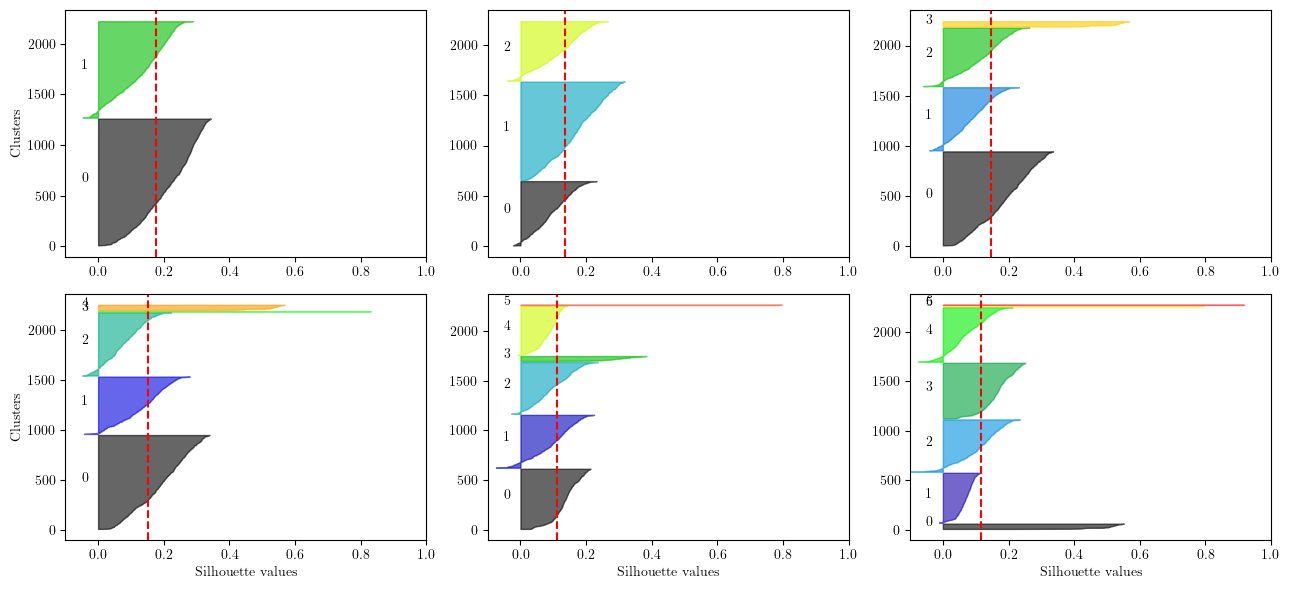

In [44]:
fig, ax = plt.subplots(2,3, figsize=(13,6))

k_values = [2,3,4,5,6,7]

m = 0
for l in range(2):
    for j in range(3):
        k = k_list[m]
        m += 1

        kmeans = KMeans(n_clusters=k, n_init=100)
        y_pred = kmeans.fit_predict(X)
        avg_silhouette = silhouette_score(X, y_pred)
        samples_silhouete = silhouette_samples(X, y_pred)

        y_lower = 10
        for i in range(k):
            i_silhouette_values = samples_silhouete[y_pred == i]
            i_silhouette_values.sort()
            size_i_silhouette = i_silhouette_values.shape[0]
            y_upper = y_lower + size_i_silhouette

            color = cm.nipy_spectral(float(i)/k)
            ax[l,j].fill_betweenx(np.arange(y_lower, y_upper), 0, i_silhouette_values, facecolor=color,
                            edgecolor=color, alpha=0.6)
            
            ax[l,j].text(-0.05, y_lower + 0.5 * size_i_silhouette, str(i))
            y_lower = y_upper + 10

        ax[l,j].axvline(avg_silhouette, linestyle='--', c='r')
        ax[l,j].set_xlim(-0.1, 1)
        if l == 1:
            ax[l,j].set_xlabel('Silhouette values')
        if j == 0:
            ax[l,j].set_ylabel('Clusters')
plt.tight_layout()
plt.show()

Let us compare customers in the scenario with 2 clusters:

In [11]:
kmeans = KMeans(n_clusters=2, n_init=1000)
y_pred = kmeans.fit_predict(X)

np.save('dataset/prediction_2_clusters.npy', y_pred)

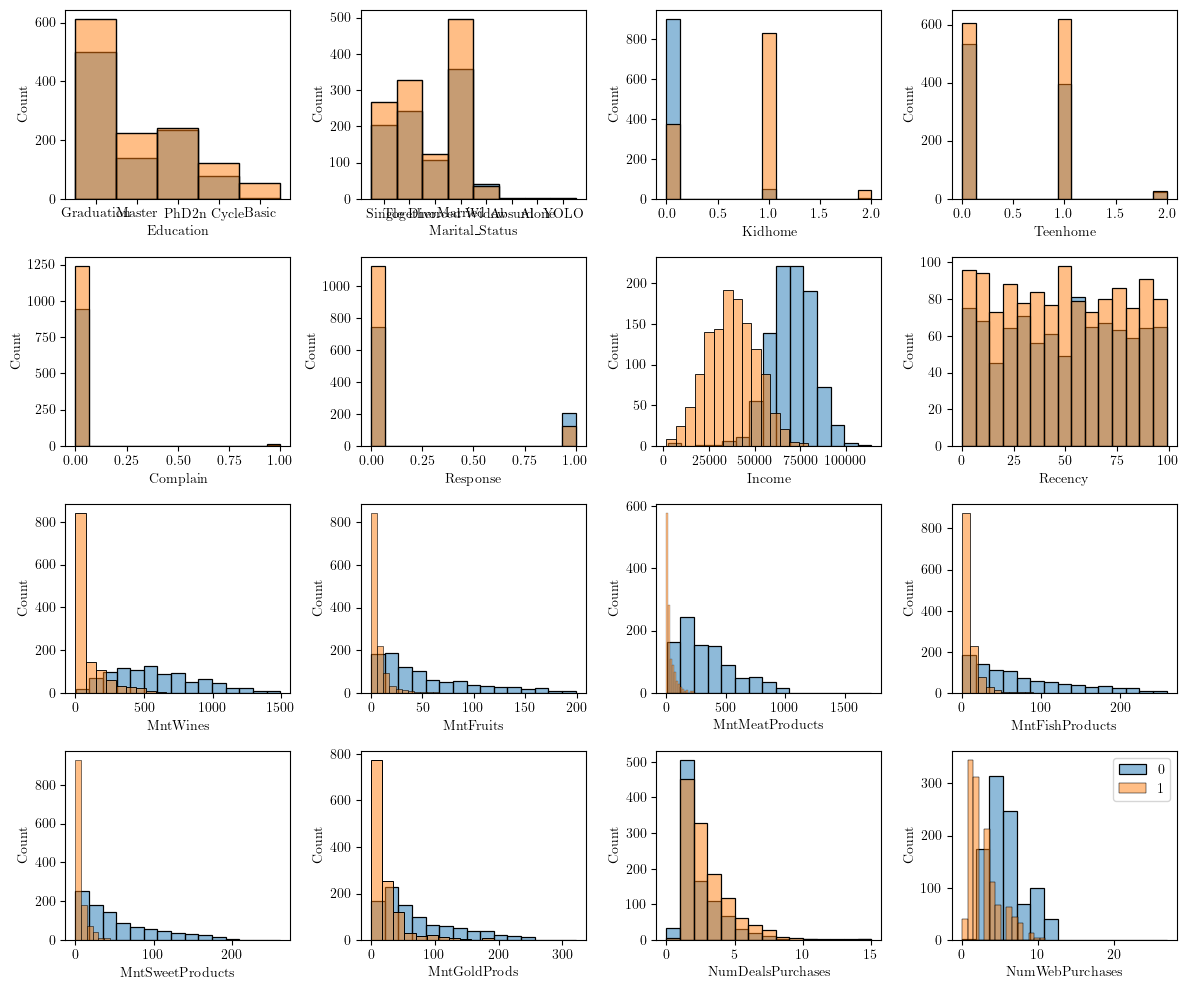

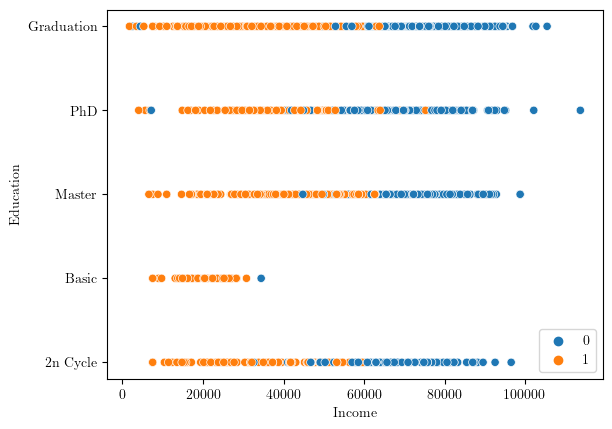

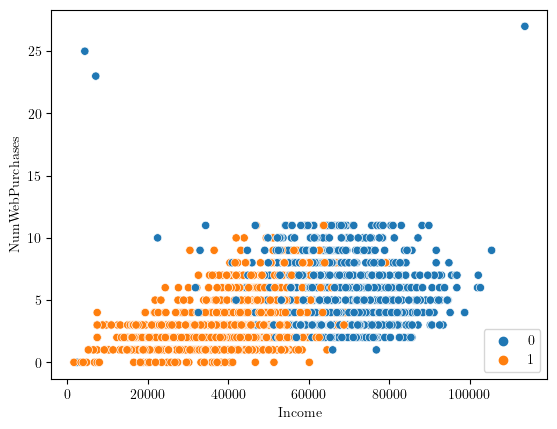

In [90]:
kmeans = KMeans(n_clusters=2, n_init=100)
y_pred = kmeans.fit_predict(X)

features = categorical_features + numerical_features

#histograms
fig, ax = plt.subplots(4,4,figsize=(12,10))

l = 0
for i in range(4):
    for j in range(4):
        sn.histplot(data=data_cleaned.iloc[y_pred == 0], x=features[l], bins=15, alpha=0.5, ax=ax[i,j], label=0)
        sn.histplot(data=data_cleaned.iloc[y_pred == 1], x=features[l], bins=15, alpha=0.5, ax=ax[i,j], label=1)
        l += 1
plt.tight_layout()
plt.legend()
plt.show()

#scatter plots
sn.scatterplot(data_cleaned, x='Income', y='Education', hue=y_pred)
# plt.ylim(0,1000)
plt.show()

sn.scatterplot(data_cleaned, x='Income', y='NumWebPurchases', hue=y_pred)
# plt.ylim(0,1000)
plt.show()

k-means clustering is being mostly impacted with **income**.

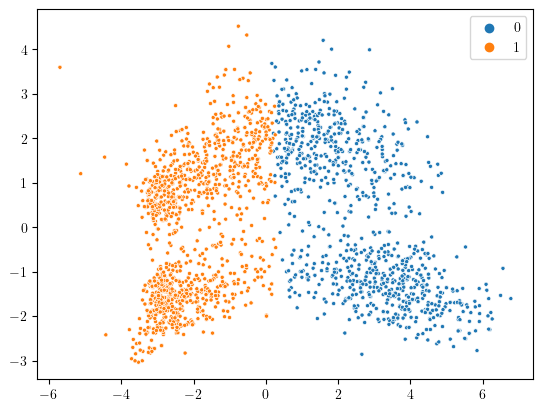

In [94]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

sn.scatterplot(x=X_pca[:,0].ravel(), y=X_pca[:,1].ravel(), marker='.', hue=y_pred)
plt.show()

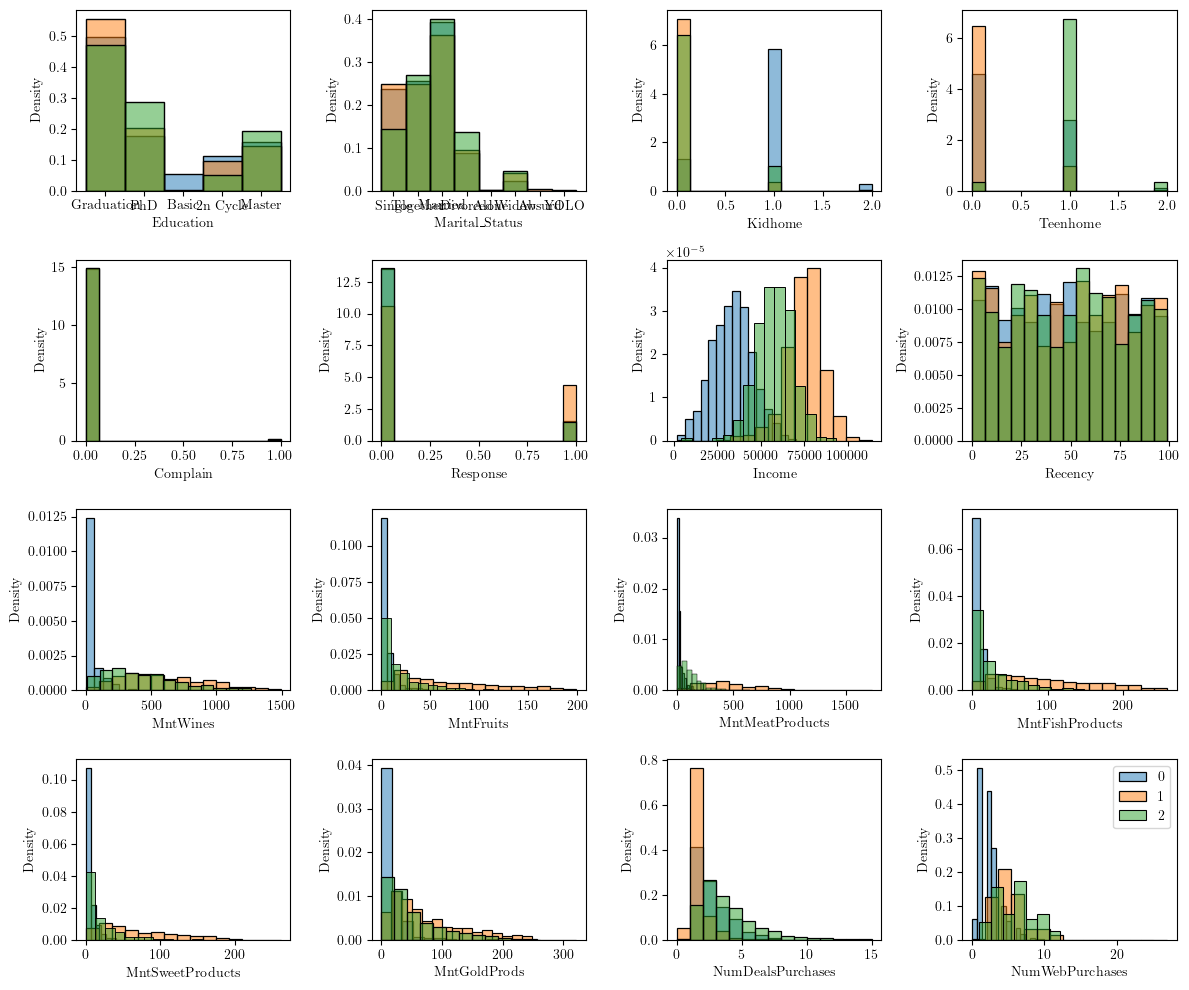

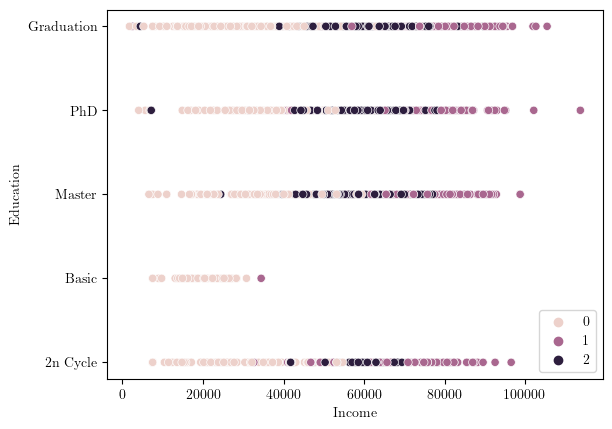

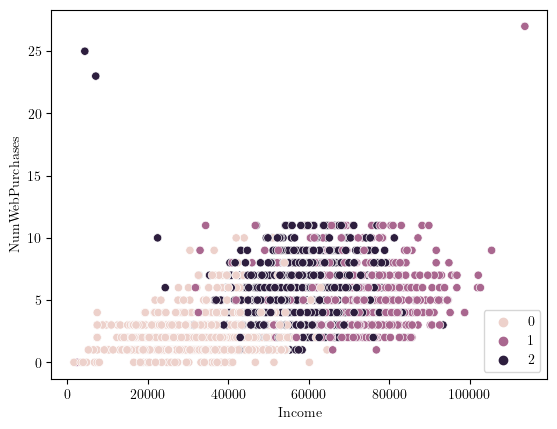

In [106]:
kmeans = KMeans(n_clusters=3, n_init=100)
y_pred = kmeans.fit_predict(X)

features = categorical_features + numerical_features

#histograms
fig, ax = plt.subplots(4,4,figsize=(12,10))

l = 0
for i in range(4):
    for j in range(4):
        sn.histplot(data=data_cleaned.iloc[y_pred == 0], x=features[l], bins=15, alpha=0.5, ax=ax[i,j], label=0, stat='density')
        sn.histplot(data=data_cleaned.iloc[y_pred == 1], x=features[l], bins=15, alpha=0.5, ax=ax[i,j], label=1, stat='density')
        sn.histplot(data=data_cleaned.iloc[y_pred == 2], x=features[l], bins=15, alpha=0.5, ax=ax[i,j], label=2, stat='density')
        l += 1
plt.tight_layout()
plt.legend()
plt.show()

#scatter plots
sn.scatterplot(data_cleaned, x='Income', y='Education', hue=y_pred)
# plt.ylim(0,1000)
plt.show()

sn.scatterplot(data_cleaned, x='Income', y='NumWebPurchases', hue=y_pred)
# plt.ylim(0,1000)
plt.show()

In [103]:
print((y_pred[y_pred == 0]).shape)
print((y_pred[y_pred == 1]).shape)
print((y_pred[y_pred == 2]).shape)

(977,)
(590,)
(638,)


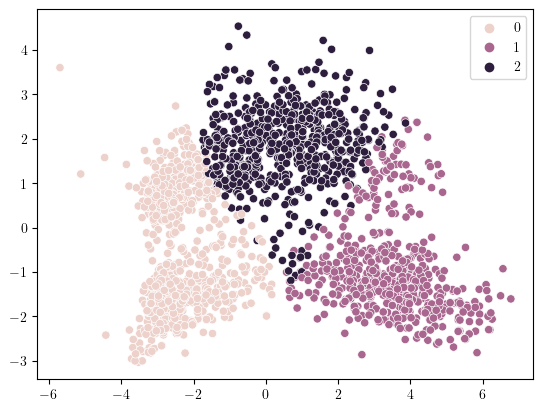

In [100]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

sn.scatterplot(x=X_pca[:,0].ravel(), y=X_pca[:,1].ravel(), marker='o', hue=y_pred)
plt.show()

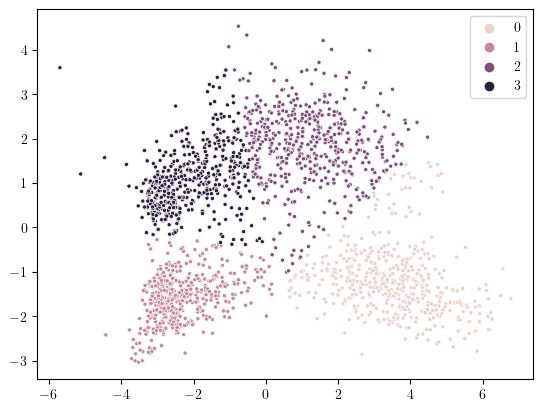

In [109]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
kmeans = KMeans(n_clusters=4, n_init=1000)
y_pca = kmeans.fit_predict(X_pca)

sn.scatterplot(x=X_pca[:,0].ravel(), y=X_pca[:,1].ravel(), marker='.', hue=y_pca)
plt.show()

Preliminar conclusion: customers could be relatively segmented with 2 and 3 clusters, partially capturing their general behavior impacted by features like their income and education. A larger number of clusters could be assigned to this analysis in the future, with PCA and t-SNE indicating that further segmentation could approach at least 4 clusters.